# Concatenation, Analysis

In [3]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from loss_functions import *
from optimization import *
from quantum_channel import *
from kraus_channels import *
from quantum_tools import *
from experimental import *
from spam import *
from scipy.stats import gaussian_kde
from quantum_circuits import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [77]:
def evaluate_channel(channel, inputs, targets):
    d = channel.d
    kl_div = KLDiv()
    loss = kl_div(channel, inputs, targets)
    return np.real(loss)/d


def calculate_channel_fittness(filename, num_layers = None):
    model_list = loader(data_path(filename + "_fitted.model"))

    d = model_list[0].channel.d
    n = int(np.log2(d))

    U1_circuit_list = []
    U2_circuit_list = []
    U3_circuit_list = []

    R1_fid_list = []
    R2_fid_list = []
    R3_fid_list = []

    U1_fid_list = []
    U2_fid_list = []
    U3_fid_list = []

    T1_fid_list = []
    T2_fid_list = []
    T12_fid_list = []
    T3_fid_list = []

    np.random.seed(42)
    random.seed(42)

    for i in tqdm(range(len(model_list)//3)):

        circuit1 = pqc_basic(n, num_layers)#.reverse_bits()
        U1 = circuit_to_matrix(circuit1)
        U1_circuit_list.append(U1)

        circuit2 = pqc_basic(n, num_layers)#.reverse_bits()
        U2 = circuit_to_matrix(circuit2)
        U2_circuit_list.append(U2)

        circuit3 = deepcopy(circuit1)
        circuit3 = circuit3.compose(circuit2)
        U3 = circuit_to_matrix(circuit3)
        U3_circuit_list.append(U3)

        #Throw-away computation to advance RNG correctly
        circuit_target_list = [circuit1, circuit2, circuit3]
        belem_concatenate = ExecuteAndCollect()
        belem_concatenate.setup_circuits(circuit_target_list, N_map = 2000-6**n)

    for i in range(len(model_list)//3):
        inputs1, targets1, _, _ = loader(data_path(filename + f"{i}0"))
        inputs2, targets2, _, _ = loader(data_path(filename + f"{i}1"))
        inputs3, targets3, _, _ = loader(data_path(filename + f"{i}2"))

        model1 = model_list[3*i]
        model2 = model_list[3*i+1]
        model3 = model_list[3*i+2]

        channel1 = model1.channel
        channel2 = model2.channel
        channel3 = model3.channel

        channel12 = channel_to_choi_map([channel1, channel2])
        channel12.spam = channel3.spam

        identity_channel1 = IdentityChannel(d)
        identity_channel1.spam = channel1.spam

        identity_channel2 = IdentityChannel(d)
        identity_channel2.spam = channel2.spam

        identity_channel3 = IdentityChannel(d)
        identity_channel3.spam = channel3.spam

        U_channel1 = ChoiMapStatic(U1_circuit_list[i], mode="unitary")
        U_channel1.spam = channel1.spam

        U_channel2 = ChoiMapStatic(U2_circuit_list[i], mode="unitary")
        U_channel2.spam = channel2.spam

        U_channel3 = ChoiMapStatic(U3_circuit_list[i], mode="unitary")
        U_channel3.spam = channel3.spam

        R1_fid_list.append(evaluate_channel(identity_channel1, inputs1, targets1))
        R2_fid_list.append(evaluate_channel(identity_channel2, inputs2, targets2))
        R3_fid_list.append(evaluate_channel(identity_channel3, inputs3, targets3)) 

        U1_fid_list.append(evaluate_channel(U_channel1, inputs1, targets1))
        U2_fid_list.append(evaluate_channel(U_channel2, inputs2, targets2))
        U3_fid_list.append(evaluate_channel(U_channel3, inputs3, targets3))

        T1_fid_list.append(evaluate_channel(channel1, inputs1, targets1))
        T2_fid_list.append(evaluate_channel(channel2, inputs2, targets2))
        T12_fid_list.append(evaluate_channel(channel12, inputs3, targets3))
        T3_fid_list.append(evaluate_channel(channel3, inputs3, targets3))


    Id_single_fid_mean = np.mean(R1_fid_list + R2_fid_list)
    Id_single_fid_std= np.std(R1_fid_list + R2_fid_list)
    
    Id_full_fid_mean = np.mean(R3_fid_list)  
    Id_full_fid_std = np.std(R3_fid_list)  

    U_single_fid_mean = np.mean(U1_fid_list + U2_fid_list)
    U_single_fid_std = np.std(U1_fid_list + U2_fid_list)
    
    U_full_fid_mean = np.mean(U3_fid_list)  
    U_full_fid_std = np.std(U3_fid_list)  
    
    T_single_fid_mean = np.mean(T1_fid_list + T2_fid_list)
    T_single_fid_std = np.std(T1_fid_list + T2_fid_list)
    
    T_concat_fid_mean = np.mean(T12_fid_list)
    T_concat_fid_std = np.std(T12_fid_list)
    
    T_full_fid_mean = np.mean(T3_fid_list)
    T_full_fid_std = np.std(T3_fid_list)
    
    mean_list = [Id_single_fid_mean, Id_full_fid_mean, U_single_fid_mean, U_full_fid_mean, T_single_fid_mean, T_full_fid_mean, T_concat_fid_mean]
    std_list = [Id_single_fid_std, Id_full_fid_std, U_single_fid_std, U_full_fid_std, T_single_fid_std, T_full_fid_std, T_concat_fid_std]

    
    return mean_list, std_list

## KL Divergence with Respect to Real Data

In [79]:
mean_list1, std_list1 = calculate_channel_fittness(filename= "belem_concatenate_2layer", num_layers = 2)

  0%|          | 0/10 [00:00<?, ?it/s]

In [80]:
Id_single_fid_mean, Id_full_fid_mean, U_single_fid_mean, U_full_fid_mean, T_single_fid_mean, T_full_fid_mean, T_concat_fid_mean = mean_list1
Id_single_fid_std, Id_full_fid_std, U_single_fid_std, U_full_fid_std, T_single_fid_std, T_full_fid_std, T_concat_fid_std = std_list1

print(f"Id Single KL-Div: {Id_single_fid_mean:.3f} +-{Id_single_fid_std:.3f}")
print(f"Id Full KL-Div: {Id_full_fid_mean:.3f} +-{Id_full_fid_std:.3f}")
print("----")
print(f"U Single KL-Div: {U_single_fid_mean:.3f} +-{U_single_fid_std:.3f}")
print(f"U Full KL-Div: {U_full_fid_mean:.3f} +-{U_full_fid_std:.3f}")
print("----")
print(f"T Single KL-Div: {T_single_fid_mean:.4f} +-{T_single_fid_std:.4f}")
print(f"T Full KL-Div: {T_full_fid_mean:.4f} +-{T_full_fid_std:.4f}")
print(f"T Concat KL-Div: {T_concat_fid_mean:.3f} +-{T_concat_fid_std:.3f}")

Id Single KL-Div: 0.130 +-0.013
Id Full KL-Div: 0.125 +-0.010
----
U Single KL-Div: 0.015 +-0.001
U Full KL-Div: 0.017 +-0.001
----
T Single KL-Div: 0.0011 +-0.0007
T Full KL-Div: 0.0007 +-0.0001
T Concat KL-Div: 0.005 +-0.001


In [81]:
mean_list2, std_list2 = calculate_channel_fittness(filename= "belem_concatenate_4layer", num_layers = 4)

  0%|          | 0/10 [00:00<?, ?it/s]

In [82]:
Id_single_fid_mean, Id_full_fid_mean, U_single_fid_mean, U_full_fid_mean, T_single_fid_mean, T_full_fid_mean, T_concat_fid_mean = mean_list2
Id_single_fid_std, Id_full_fid_std, U_single_fid_std, U_full_fid_std, T_single_fid_std, T_full_fid_std, T_concat_fid_std = std_list2

print(f"Id Single KL-Div: {Id_single_fid_mean:.3f} +-{Id_single_fid_std:.3f}")
print(f"Id Full KL-Div: {Id_full_fid_mean:.3f} +-{Id_full_fid_std:.3f}")
print("----")
print(f"U Single KL-Div: {U_single_fid_mean:.3f} +-{U_single_fid_std:.3f}")
print(f"U Full KL-Div: {U_full_fid_mean:.3f} +-{U_full_fid_std:.3f}")
print("----")
print(f"T Single KL-Div: {T_single_fid_mean:.4f} +-{T_single_fid_std:.4f}")
print(f"T Full KL-Div: {T_full_fid_mean:.4f} +-{T_full_fid_std:.4f}")
print(f"T Concat KL-Div: {T_concat_fid_mean:.3f} +-{T_concat_fid_std:.3f}")

Id Single KL-Div: 0.127 +-0.009
Id Full KL-Div: 0.120 +-0.006
----
U Single KL-Div: 0.017 +-0.002
U Full KL-Div: 0.020 +-0.001
----
T Single KL-Div: 0.0007 +-0.0002
T Full KL-Div: 0.0003 +-0.0001
T Concat KL-Div: 0.005 +-0.002


In [83]:
mean_list3, std_list3 = calculate_channel_fittness(filename= "belem_concatenate_8layer", num_layers = 8)

  0%|          | 0/10 [00:00<?, ?it/s]

In [84]:
Id_single_fid_mean, Id_full_fid_mean, U_single_fid_mean, U_full_fid_mean, T_single_fid_mean, T_full_fid_mean, T_concat_fid_mean = mean_list3
Id_single_fid_std, Id_full_fid_std, U_single_fid_std, U_full_fid_std, T_single_fid_std, T_full_fid_std, T_concat_fid_std = std_list3

print(f"Id Single KL-Div: {Id_single_fid_mean:.3f} +-{Id_single_fid_std:.3f}")
print(f"Id Full KL-Div: {Id_full_fid_mean:.3f} +-{Id_full_fid_std:.3f}")
print("----")
print(f"U Single KL-Div: {U_single_fid_mean:.3f} +-{U_single_fid_std:.3f}")
print(f"U Full KL-Div: {U_full_fid_mean:.3f} +-{U_full_fid_std:.3f}")
print("----")
print(f"T Single KL-Div: {T_single_fid_mean:.4f} +-{T_single_fid_std:.4f}")
print(f"T Full KL-Div: {T_full_fid_mean:.4f} +-{T_full_fid_std:.4f}")
print(f"T Concat KL-Div: {T_concat_fid_mean:.3f} +-{T_concat_fid_std:.3f}")

Id Single KL-Div: 0.124 +-0.006
Id Full KL-Div: 0.115 +-0.006
----
U Single KL-Div: 0.020 +-0.002
U Full KL-Div: 0.028 +-0.003
----
T Single KL-Div: 0.0005 +-0.0005
T Full KL-Div: 0.0005 +-0.0013
T Concat KL-Div: 0.003 +-0.001


In [85]:
mean_list = np.array([mean_list1, mean_list2, mean_list3])
std_list = np.array([std_list1, std_list2, std_list3])

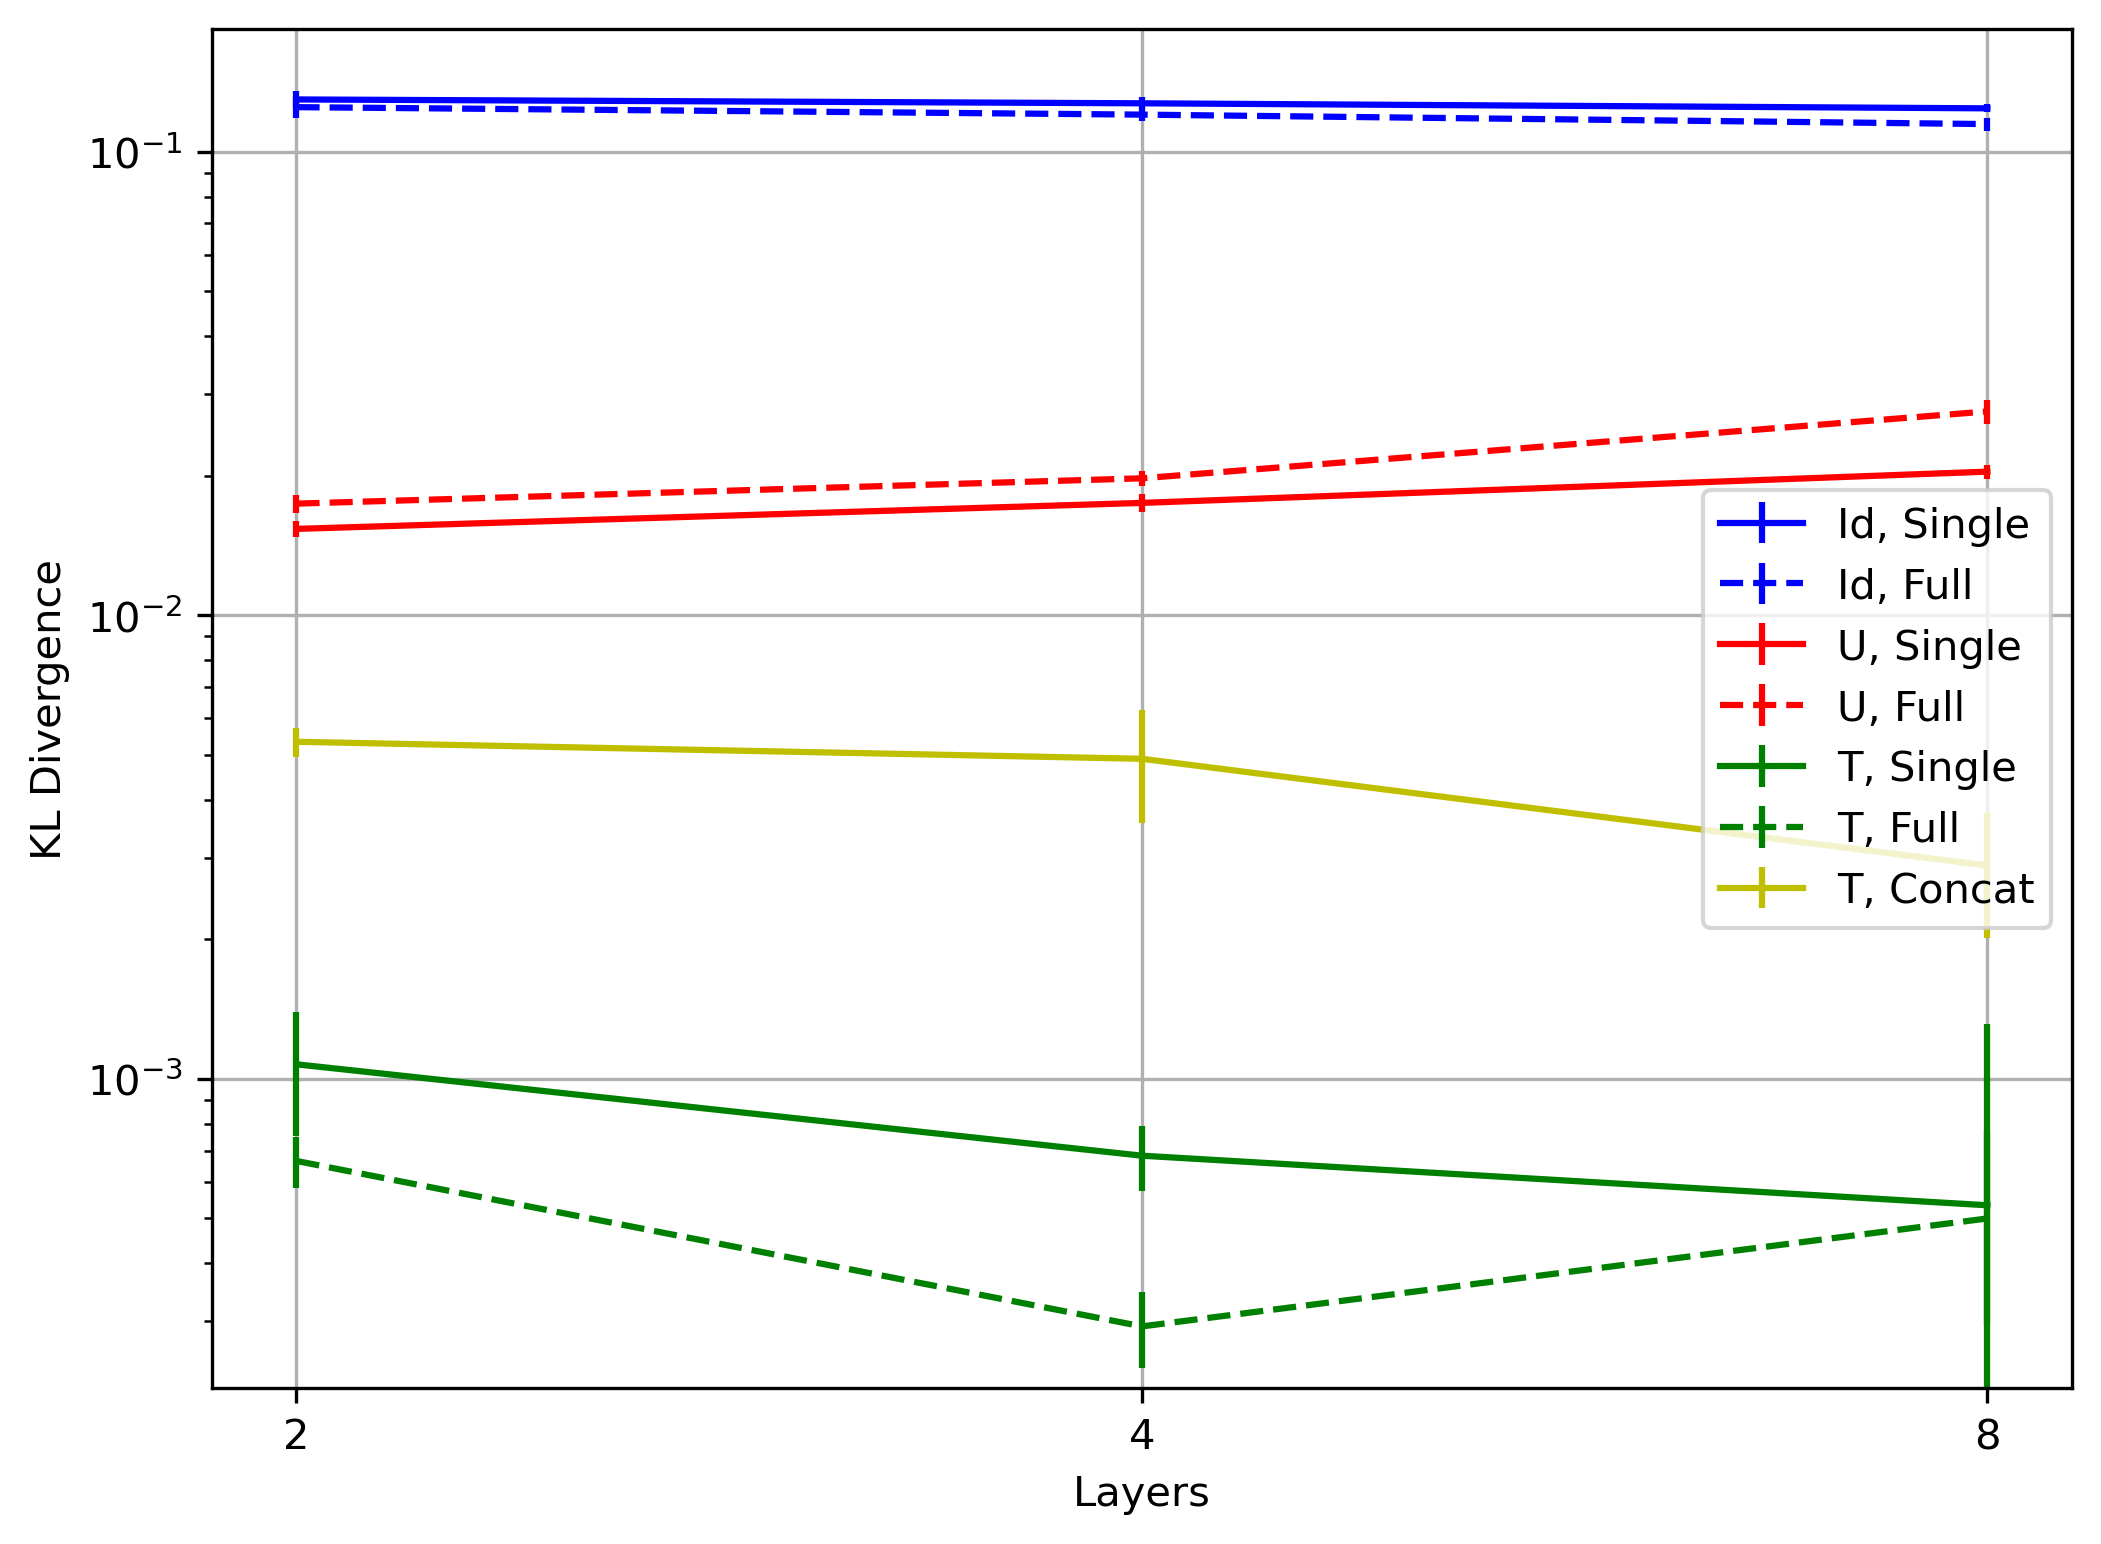

In [91]:
ticks_list = (1,2,3)
labels_list = [2, 4, 8]


fig = plt.figure(figsize=(8,6), dpi = 300, facecolor='w', edgecolor='k')
plt.xticks(ticks_list, labels_list)

plt.errorbar(x, mean_list[:,0], yerr = 2*std_list[:,0]/np.sqrt(20), fmt = "b-")
plt.errorbar(x, mean_list[:,1], yerr = 2*std_list[:,1]/np.sqrt(10), fmt = "b--")
plt.errorbar(x, mean_list[:,2], yerr = 2*std_list[:,2]/np.sqrt(20), fmt = "r-")
plt.errorbar(x, mean_list[:,3], yerr = 2*std_list[:,3]/np.sqrt(10), fmt = "r--")
plt.errorbar(x, mean_list[:,4], yerr = 2*std_list[:,4]/np.sqrt(20), fmt = "g-")
plt.errorbar(x, mean_list[:,5], yerr = 2*std_list[:,5]/np.sqrt(10), fmt = "g--")
plt.errorbar(x, mean_list[:,6], yerr = 2*std_list[:,6]/np.sqrt(10), fmt = "y")
plt.legend(["Id, Single", "Id, Full", "U, Single", "U, Full", "T, Single", "T, Full", "T, Concat"])
plt.yscale("log")
plt.xlabel("Layers")
plt.ylabel("KL Divergence")
plt.grid()
plt.show()